<h1> <center><font color='green' > <b>AGN Redshift Predicetion for AGNDB</b></font> </center></h1>

# Model Performance Evaluation
by Sicong Huang <br> \
<font color='blue'>Python Version: 3.6.5 <br>
AGNDB Version: 1.1.0

# Import

In [128]:
# System
import os
import glob
from tqdm import tqdm
from IPython.display import Markdown, display, Audio

# Web Scraping

# Data Analysis
import pandas as pd
import numpy as np

# Machine Learning
from scipy import stats
import sklearn
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.gridspec import SubplotSpec
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

# Functions

In [3]:
def sound_effect(fail=0):
    """
    Play a sound when job is finished
    """
    if fail == 0:
        sound_file = '/data/home/sicong/sounds/jobs-done_1.mp3'
        display(Audio(sound_file, autoplay=True))
    else:
        sound_file = '/data/home/sicong/sounds/oh-shit-im-sorry_0001.mp3'
        display(Audio(sound_file, autoplay=True))

In [4]:
def printmd(string):
    """
    print in markdown style
    """
    display(Markdown(string))

In [127]:
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

In [31]:
def normalized_SD(y, y_hat):    
    """
    Calculate the Normalized Standard Deviation
    """
    assert y.shape == y_hat.shape, 'y.shape != y_hat.shape'
    kernel = (y_hat-y)
    div = 1+y
    kernel = kernel/div
    kernel = kernel**2
    
    sigma = np.sqrt(np.sum(kernel)/kernel.shape[0])
    
    return sigma

In [32]:
def NMAD(y, y_hat):    
    """
    Calculate the Normalized Median Absolute Deviation
    """
    assert y.shape == y_hat.shape, 'y.shape != y_hat.shape'
    
    kernel = np.abs(y_hat-y)/(y+1)
    med = np.median(kernel)
    nmad = 1.48*med
    
    return nmad

In [56]:
def sigma_68(y, y_hat):    
    """
    Calculate the width in which 
    falls the 68% of the  Δ𝑧(𝑛𝑜𝑟𝑚)  distribution
    """
    assert y.shape == y_hat.shape, 'y.shape != y_hat.shape'
    
    kernel = (y_hat-y)/(y+1)
    kernel = np.sort(kernel)
    ind_16 = round(kernel.shape[0]*0.16)
    ind_84 = round(kernel.shape[0]*0.84)
    width = kernel[ind_84] - kernel[ind_16]
    
    return width

In [49]:
def outlier_frac(y, y_hat):    
    """
    Calculate the fraction (percentage) of outliers
    """
    assert y.shape == y_hat.shape, 'y.shape != y_hat.shape'
    
    kernel = np.abs(y_hat-y)/(y+1)
    y_dis = kernel[(kernel > 0.15)]
    frac = y_dis.shape[0]/kernel.shape[0]
    
    return frac

In [78]:
def accuracy(y_true, y_pred):
    """
    calculate the accuracy based on mean absolute percentage error
    """
    # Calculate the absolute errors
    errors = abs(y_pred - y_true)

    # Calculate mean absolute percentage error (MAPE)
    mape = 100 * (errors / y_true)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    accuracy = str(round(accuracy, 2))+'%' 
    return accuracy 

# Read train/dev/test sets

In [52]:
df_train = pd.read_pickle('agnz_train.pkl')
df_dev = pd.read_pickle('agnz_dev.pkl')

In [53]:
# True lables
y_train = np.array(df_train['best_z'])
y_dev = np.array(df_dev['best_z'])

# Read results

In [54]:
# Logestic Regression
%store -r yhat_train_lr
%store -r yhat_dev_lr

# Decision Tree
%store -r yhat_train_rf
%store -r yhat_dev_rf

# KNN
%store -r yhat_train_knn
%store -r yhat_dev_knn

# CNN
%store -r yhat_train_nn
%store -r yhat_dev_nn

# Model Evaluation

## Metrics

$\hat{y}$ is the predicted value of the i-th sample, and 
y is the corresponding true value.

1. <font color='green'>Mean Absolute Error (L1 norm loss)</font>: 
    \begin{equation}
    MAE(y,\hat{y}) = \frac{1}{N}\sum^{N}|\hat{y}_{i} - y_i|
    \end{equation}

2. <font color='green'>Normalized Standard Deviation </font>:
    - defined as:
    \begin{equation}
    \sigma_{\Delta z(norm)} = \sqrt{\frac{1}{N}\sum^{N}(\frac{\hat{y}_{i} - y_i}{y_i+1})^2}
    \end{equation}
    - Punish large error

3. <font color='green'>Normalized Median Absolute Deviation (NMAD) </font>: 
    - defined as:
    \begin{equation}
    \sigma_{NMAD} = 1.48 \times median|\frac{\hat{y} - y}{y+1}|
    \end{equation}
    - Measure variance

4. <font color='green'>68% Width </font>: 
    - defined as the width in which falls the 68% of the $\Delta z(norm)$ distribution:

5. <font color='green'> Outlier fraction </font>: 
    - defined as:
    \begin{equation}
    \eta = \textrm{fraction of } |\frac{\hat{y} - y}{y+1}| > 0.15
    \end{equation}
    - the fraction (percentage) of outliers
    
5. <font color='green'> Accuracy </font>: 
    - defined as:
    \begin{equation}
    \textrm{Accuracy} = 1 - \textrm{MAPE} = 1 - \frac{1}{N} \sum^{N}\frac{|\hat{y}_i - y_i|}{y_i} 
    \end{equation}
    - the fraction (percentage) of outliers

### Evaluate on Validation Set

In [79]:
# Linear Regression
mae_dev_lr = mean_absolute_error(y_dev, yhat_dev_lr)
nsd_dev_lr = normalized_SD(y_dev, yhat_dev_lr)
nmad_dev_lr = NMAD(y_dev, yhat_dev_lr)
w68_dev_lr = sigma_68(y_dev, yhat_dev_lr)
out_dev_lr = outlier_frac(y_dev, yhat_dev_lr)
acc_dev_lr = accuracy(y_dev, yhat_dev_lr)

# Random Forest
mae_dev_rf = mean_absolute_error(y_dev, yhat_dev_rf)
nsd_dev_rf = normalized_SD(y_dev, yhat_dev_rf)
nmad_dev_rf = NMAD(y_dev, yhat_dev_rf)
w68_dev_rf = sigma_68(y_dev, yhat_dev_rf)
out_dev_rf = outlier_frac(y_dev, yhat_dev_rf)
acc_dev_rf = accuracy(y_dev, yhat_dev_rf)

# KNN
mae_dev_knn = mean_absolute_error(y_dev, yhat_dev_knn)
nsd_dev_knn = normalized_SD(y_dev, yhat_dev_knn)
nmad_dev_knn = NMAD(y_dev, yhat_dev_knn)
w68_dev_knn = sigma_68(y_dev, yhat_dev_knn)
out_dev_knn = outlier_frac(y_dev, yhat_dev_knn)
acc_dev_knn = accuracy(y_dev, yhat_dev_knn)

# Z_NN
mae_dev_nn = mean_absolute_error(y_dev, yhat_dev_nn)
nsd_dev_nn = normalized_SD(y_dev, yhat_dev_nn)
nmad_dev_nn = NMAD(y_dev, yhat_dev_nn)
w68_dev_nn = sigma_68(y_dev, yhat_dev_nn)
out_dev_nn = outlier_frac(y_dev, yhat_dev_nn)
acc_dev_nn = accuracy(y_dev, yhat_dev_nn)

### Evaluate on Training Set

In [80]:
# Linear Regression
mae_train_lr = mean_absolute_error(y_train, yhat_train_lr)
nsd_train_lr = normalized_SD(y_train, yhat_train_lr)
nmad_train_lr = NMAD(y_train, yhat_train_lr)
w68_train_lr = sigma_68(y_train, yhat_train_lr)
out_train_lr = outlier_frac(y_train, yhat_train_lr)
acc_train_lr = accuracy(y_train, yhat_train_lr)

# Random Forest
mae_train_rf = mean_absolute_error(y_train, yhat_train_rf)
nsd_train_rf = normalized_SD(y_train, yhat_train_rf)
nmad_train_rf = NMAD(y_train, yhat_train_rf)
w68_train_rf = sigma_68(y_train, yhat_train_rf)
out_train_rf = outlier_frac(y_train, yhat_train_rf)
acc_train_rf = accuracy(y_train, yhat_train_rf)

# KNN
mae_train_knn = mean_absolute_error(y_train, yhat_train_knn)
nsd_train_knn = normalized_SD(y_train, yhat_train_knn)
nmad_train_knn = NMAD(y_train, yhat_train_knn)
w68_train_knn = sigma_68(y_train, yhat_train_knn)
out_train_knn = outlier_frac(y_train, yhat_train_knn)
acc_train_knn = accuracy(y_train, yhat_train_knn)

# Z_NN
mae_train_nn = mean_absolute_error(y_train, yhat_train_nn)
nsd_train_nn = normalized_SD(y_train, yhat_train_nn)
nmad_train_nn = NMAD(y_train, yhat_train_nn)
w68_train_nn = sigma_68(y_train, yhat_train_nn)
out_train_nn = outlier_frac(y_train, yhat_train_nn)
acc_train_nn = accuracy(y_train, yhat_train_nn)

In [104]:
metric_data = np.array((['Linear Regression', 'Train', mae_train_lr, nsd_train_lr, nmad_train_lr, w68_train_lr, out_train_lr, acc_train_lr],
                        ['Linear Regression', 'Validation', mae_dev_lr, nsd_dev_lr, nmad_dev_lr, w68_dev_lr, out_dev_lr, acc_dev_lr],
                        ['Random Forest', 'Train', mae_train_rf, nsd_train_rf, nmad_train_rf, w68_train_rf, out_train_rf, acc_train_rf],
                        ['Random Forest', 'Validation', mae_dev_rf, nsd_dev_rf, nmad_dev_rf, w68_dev_rf, out_dev_rf, acc_dev_rf],
                        ['KNN', 'Train', mae_train_knn, nsd_train_knn, nmad_train_knn, w68_train_knn, out_train_knn, acc_train_knn],
                        ['KNN', 'Validation', mae_dev_knn, nsd_dev_knn, nmad_dev_knn, w68_dev_knn, out_dev_knn, acc_dev_knn],
                        ['Neural Network', 'Train', mae_train_nn, nsd_train_nn, nmad_train_nn, w68_train_nn, out_train_nn, acc_train_nn],
                        ['Neural Network', 'Validation',mae_dev_nn, nsd_dev_nn, nmad_dev_nn, w68_dev_nn, out_dev_nn, acc_dev_nn]))

df_scores = pd.DataFrame(metric_data, 
            columns=['Algorithm', 'Set', 'MAE', r'$\sigma_{\Delta z}$', 
                     r'NMAD', '68% Width', r'$\eta$', 'Accuracy'])
for col in df_scores.columns.values:
    if col not in ['Algorithm', 'Set', 'Accuracy']:
        df_scores[col] = df_scores[col].astype(float)

In [105]:
df_scores.to_csv('./results/scores.csv', index=False)

In [106]:
df_scores = pd.read_csv('./results/scores.csv')

In [107]:
df_scores

,Algorithm,Set,MAE,$\sigma_{\Delta z}$,NMAD,68% Width,$\eta$,Accuracy
0,Linear Regression,Train,0.26,0.17,0.10,0.23,0.21,76.5%
1,Linear Regression,Validation,0.27,0.24,0.10,0.22,0.21,76.49%
2,Random Forest,Train,0.08,0.06,0.03,0.06,0.03,93.23%
3,Random Forest,Validation,0.21,0.15,0.07,0.16,0.14,82.35%
4,KNN,Train,0.23,0.15,0.08,0.19,0.17,79.75%
5,KNN,Validation,0.25,0.16,0.09,0.21,0.19,78.96%
6,Neural Network,Train,0.16,0.13,0.05,0.10,0.08,86.73%
7,Neural Network,Validation,0.17,0.14,0.05,0.11,0.09,86.05%


### Actual vs Fitted Values for Redshift

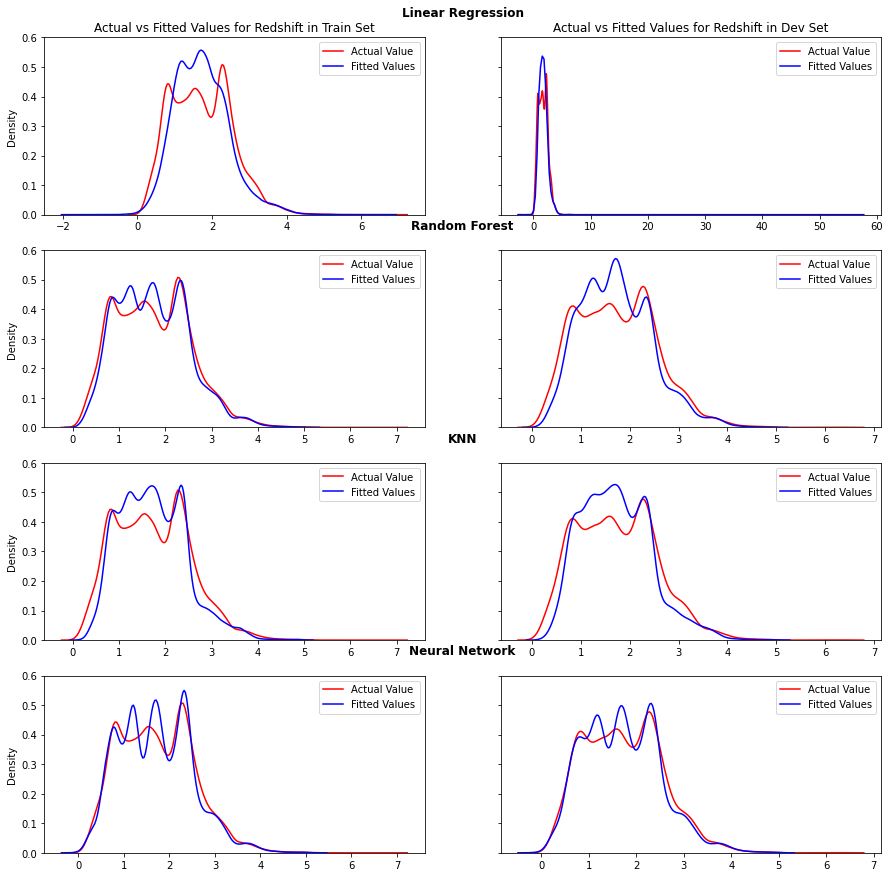

In [130]:
fig, axes = plt.subplots(4, 2, sharey=True, figsize=(15, 15))
# linear regression
sns.kdeplot(x=y_train, ax=axes[0,0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_lr, ax=axes[0,0], color="b", label="Fitted Values" )
axes[0,0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[0,1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_lr, ax=axes[0,1], color="b", label="Fitted Values")
axes[0,1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[0,0].legend()
axes[0,1].legend()

# Random Forest
sns.kdeplot(x=y_train, ax=axes[1,0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_rf, ax=axes[1,0], color="b", label="Fitted Values" )
#axes[1,0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[1,1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_rf, ax=axes[1,1], color="b", label="Fitted Values")
#axes[1,1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[1,0].legend()
axes[1,1].legend()

# KNN
sns.kdeplot(x=y_train, ax=axes[2,0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_knn, ax=axes[2,0], color="b", label="Fitted Values" )
#axes[2,0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[2,1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_knn, ax=axes[2,1], color="b", label="Fitted Values")
#axes[2,1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[2,0].legend()
axes[2,1].legend()

# ZNN
sns.kdeplot(x=y_train, ax=axes[3,0], color="r", label="Actual Value")
sns.kdeplot(x=yhat_train_nn, ax=axes[3,0], color="b", label="Fitted Values" )
#axes[3,0].set_title('Actual vs Fitted Values for Redshift in Train Set')

sns.kdeplot(x=y_dev, ax=axes[3,1], color="r", label="Actual Value")
sns.kdeplot(x=yhat_dev_nn, ax=axes[3,1], color="b", label="Fitted Values")
#axes[3,1].set_title('Actual vs Fitted Values for Redshift in Dev Set')

axes[3,0].legend()
axes[3,1].legend()

grid = plt.GridSpec(4, 2)
create_subtitle(fig, grid[0, ::], 'Linear Regression')
create_subtitle(fig, grid[1, ::], 'Random Forest')
create_subtitle(fig, grid[2, ::], 'KNN')
create_subtitle(fig, grid[3, ::], 'Neural Network')

plt.savefig('./results/z_dist.pdf', dpi=300)
plt.show();

# Result
Version 1: agnz_train.pkl

<font color='blue'>Conclusion:</font>
- The best performance overall goes to Neural Network, with accuracy ~ 86% for both training and dev set. 
- The random forest achieves 93% accuracy for training set, but drops down to 82% for dev set, indicating overfitting. Try to tune parameters and limit the size of the trees.
- The linear regression performs poorly in our case, possilbly due to failure to model the redshift distribution, and also extreme values appear in dev set prediction.
    
<font color='blue'>Possible Improvement:</font>
- The distribution of redshift is not Gaussian, maybe getting more data would help.